In [1]:
import sys
import os
import SimpleITK
import numpy
import matplotlib.pyplot
import subprocess
import json
import config
import getData
import segmentation

sys.path.append(os.path.join(os.path.expanduser('~'),'software','src','nixSuite','wrapper'))
import nixWrapper
nixWrapper.loadLibrary('labkeyInterface')
import labkeyInterface
import labkeyFileBrowser
import labkeyDatabaseBrowser

#manipulate segmentations
#rewrite this
#nim=getPatientNIM(pId)



remoteSourcesURL https://git0.fmf.uni-lj.si/studen/nixSuite/raw/master/remoteResources/resources.json
{'labkeyInterface': {'url': 'https://git0.fmf.uni-lj.si/studen/labkeyInterface/archive/master.zip', 'branch': 'master', 'modules': []}, 'irAEMM': {'url': 'https://git0.fmf.uni-lj.si/studen/iraemm/archive/master.zip', 'branch': 'master', 'modules': ['iraemmBrowser']}, 'SlicerLabkeyExtension': {'url': 'https://git0.fmf.uni-lj.si/studen/SlicerLabkeyExtension/archive/SlicerExtensionIndex.zip', 'branch': 'SlicerExtensionIndex', 'modules': ['labkeyBrowser']}, 'limfomiPET': {'url': 'https://git0.fmf.uni-lj.si/studen/limfomiPET/archive/master.zip', 'branch': 'master', 'modules': ['imageBrowser']}, 'parseConfig': {'url': 'https://git0.fmf.uni-lj.si/studen/parseConfig/archive/master.zip', 'branch': 'master', 'modules': []}, 'orthancInterface': {'url': 'https://git0.fmf.uni-lj.si/studen/orthancInterface/archive/master.zip', 'branch': 'master', 'modules': []}}


In [2]:
#

fsetup='../template/cardiacSPECT.json'
with open(fsetup,'r') as f:
    setup=json.load(f)
    
net=labkeyInterface.labkeyInterface()
fconfig=os.path.join(os.path.expanduser('~'),'.labkey',setup['network'])
net.init(fconfig)
net.getCSRF()
db=labkeyDatabaseBrowser.labkeyDB(net)
fb=labkeyFileBrowser.labkeyFileBrowser(net)
#rewrite this
#nim=getPatientNIM(pId)


User: andrej studen CSRF: be9cfe837ecd4871d3952652b41ca8c1


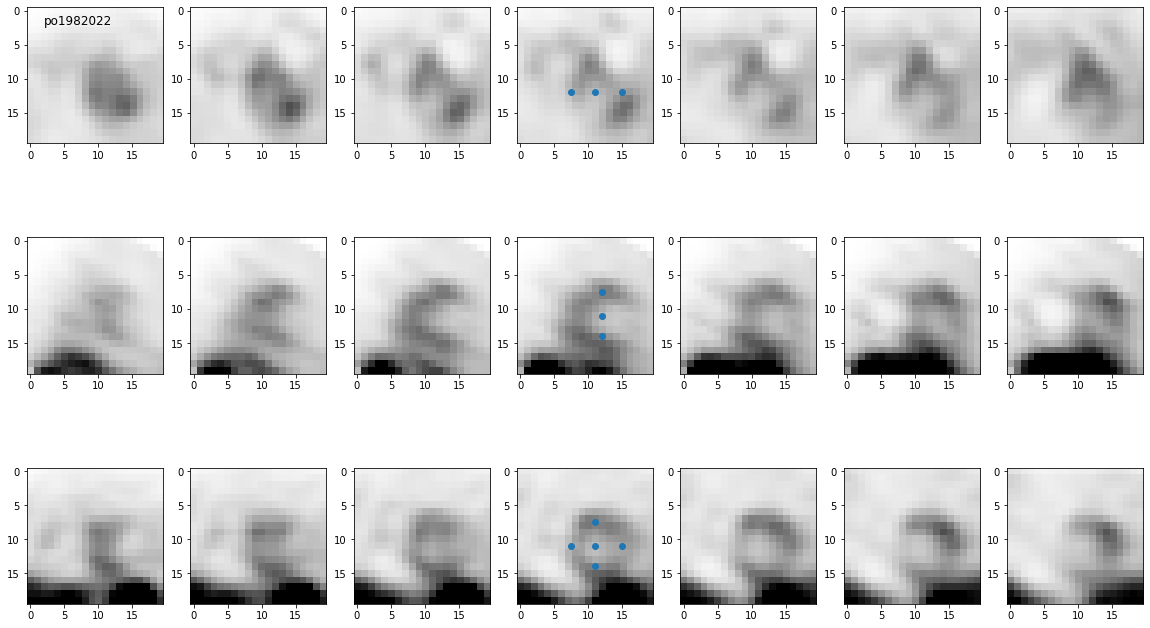

In [5]:
pId='po1982022'
cx={}
#cx[pId]=[32,31,31]
#pId='pred15052022'
#cx[pId]=[30,32,31]
#order
#[green,blue,red]

fp={'0':[],'1':[],'2':[]}

visitId='MIR'
idFilter={'variable':'PatientId','value':pId,'oper':'eq'}
visitFilter={'variable':'visitName','value':visitId,'oper':'eq'}

rows=getData.getPatients(db,setup,[idFilter,visitFilter])

r=rows[0]
nim=segmentation.getPatientNIM(r,setup)
#i labels segments
#ns=16
#for i in numpy.arange(ns):
#    sNum=r['SequenceNum']+0.0100*i
#seqFilter={'variable':'SequenceNum','value':'{:.2f}'.format(sNum),'oper':'eq'}
rows=getData.getSegmentation(db,setup,[idFilter,visitFilter])
    
if len(rows)==0:
    print('Not found for s={}'.format(sNum))
    fp=segmentation.guessPixelPosition(*cx[pId])
else:
    for q in rows:
        #print(q)
        slices=q['sliceId'].split(';')
        for s in slices:
            fp[s].append([float(x) for x in [q['x'],q['y'],q['z']]])
        #first point is (sx,sy,sz)

oz=0
rz=4
#update last 6 points 
sx=fp['0'][0][0]
sy=fp['0'][0][1]
sz=fp['0'][0][2]
slc=[int(x) for x in fp['0'][0]]
#print('Center ({})'.format(slc))

cut0=20
w0=20
cut1=20
w1=20
cut2=20
w2=20
vmax=1000
vmin=0
nd=3
fig,ax=matplotlib.pyplot.subplots(3,2*nd+1,figsize=(20,12))
for i in numpy.arange(0,2*nd+1):
    ax[0,i].imshow(nim[cut2:cut2+w2,slc[1]-nd+i,cut0:cut0+w0],cmap='gray_r',vmax=vmax,vmin=vmin)
    ax[1,i].imshow(nim[cut2:cut2+w2,cut0:cut0+w0,slc[2]-nd+i].T,cmap='gray_r',vmax=vmax,vmin=vmin)
    ax[2,i].imshow(nim[slc[0]-nd+i,cut1:cut1+w1,cut1:cut1+w1],cmap='gray_r',vmax=vmax,vmin=vmin)
    if i==nd:
        pt=fp['0']
        ax[0,i].scatter([x[2]-cut0 for x in pt],[x[0]-cut2 for x in pt])
        pt=fp['1']
        ax[1,i].scatter([x[0]-cut2 for x in pt],[x[1]-cut0 for x in pt])
        pt=fp['2']
        ax[2,i].scatter([x[2]-cut1 for x in pt],[x[1]-cut1 for x in pt])
        
    if i==0:
        ax[0,i].text(2,2,pId,fontsize='large')
          
        

In [ ]:
#rarely used. Mostly, segmentation points are edited in LabKey
rows=getData.getPatients(db,setup)
for r in rows:
    print('******{}******'.format(config.getCode(r,setup)))
    segmentation.writeSegmentation(db,r,setup)